# Spike Tutorial -- Part 1

## Data Description:

This data set is recorded from auditory cortex in an awake mouse. This was a VGAT-cre mouse that was injected with a FLEX-ChR2 virus, which encodes an excitatory opsin that will selectively express in VGAT cells in this mouse line. The idea here is that when you shine blue light on the injection site, inhibitory VGAT neurons (VGAT is a pan-inhibitory neuronal marker) will activate, and through massive inhibition shut down most of the other neurons in the area.

While there were several stimuli run during this recording, we will focus on only one of them: a set of dynamic random chord (DRC) stimuli which alternate between low and high contrast, interleaved with laser stimulation.

    
## Neural Data
This is spiking data recorded from a laminar probe. We'll focus mostly on one neuron in this notebook, but there are about 50 neurons in this data set.

If you're not familiar working with spike recordings, there a few important things you need:
1. **The spike times:** here, these are contained in a file called spike_times.npy, and are coded in samples from the start of the recording.
2. **Event times:** these are trigger times (typically in the form of 5 volt square pulses) that are locked to stimulus events (in our case, contrast transitions and laser pulse onsets and offsets).
3. **Spike identity:** having a lot of spikes is not necessarily useful unless you know which neurons they come from. Spike identity is usually assigned during spike sorting.
4. **Stimulus information:** knowing which stimulus was presented when is *essential*. The usual practice is to save some sort of stimulus index that assigns which stimulus is associated with which event time.

Those are the basics, we'll cover the details as we go!

First lets import useful modules that we're already familiar with (numpy, matplotlib, pandas, and os for path stuff)


In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle


%matplotlib inline

## Stimulus Events

First we want to deal with stimulus events. With our recording system, there are a couple different types, I'll call them *messages* and *events*. First we'll focus on *messages*.

*messages* are events that are manually typed into the recording computer at different parts of the recording. They're good for logging stimulus blocks, notes about recording quality, or errors. They have two important aspects, the text of the message and the time it was logged.

The messages for this recording are saved in two files in the folder `'_data/messages'` called `'text.npy'` and `'timestamps.npy'`

First define a filepath to your different files (HINT: `os.path.join` is useful here), then load them using `np.load`. Save the text in a variable called `msgText`, and the timestamps in a variable called `msgSample`

In [2]:
# load message data
root = '_data'

msgText = np.load(os.path.join(root,'messages','text.npy'))
msgSample = np.load(os.path.join(root,'messages','timestamps.npy'))

Look at the contents of each, and note the type and shape. They are numpy arrays of the same size:
- In the text array, each value is the text that I typed in to express something about the upcoming stimuli.
- In the sample array is the timestamp for each of those text logs. 

Take special note of the values in `msgSample`... what kind of numbers are they? What do you think they correspond to? (we will come back to this shortly, but the variable name is a clue)

In [3]:
msgText.shape

(5,)

Lets move on to the events: using the same methods as above, load the event files `'channel_states.npy'` and `'timestamps.npy'` from the `'_data/events'` folder. Name the variables `evState` and `evSample`, respectively.

In [4]:
# load event data
evState = np.load(os.path.join(root,'events','channel_states.npy'))
evSample = np.load(os.path.join(root,'events','timestamps.npy'))

Knowing how to visualize the structure of the events is key in starting to build an analysis pipeline.

The first way I typically visualize events is by plotting the absolute event times against the difference between each event.

(side note: I will probably use the terms samples and clock times interchangeably, I apologize in advance)

**Try this:**
- assign event times on the x axis
- event differences on y (HINT: there is an np function that can compute the **diff**erence between array values)
- (take care to match the array lengths)
- plot as black dots, and make the markersize pretty small, like 1 or 2
- try and do it all in one line if you want

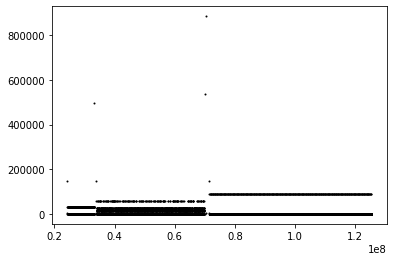

In [5]:
# event exploration plot here:
# %matplotlib qt
plt.plot(evSample[:-1],np.diff(evSample),'k.',markersize=2)

Look at the plot, what is the range of the x and y axis? It's pretty large, right? This is because all of the events are encoded in sample numbers, or, the number of ticks the clock on the recording computer made. We want to convert this to seconds, but to do this, we need to know the sample rate of the recording clock and the recording start time.

To illustrate the meaning of the recording start time, look at the value of the first `evSample`.

In [6]:
evSample[0]

24205772

If you loaded it correctly, it should be `24205772`. That is already pretty big! 

This is because the recording system records events relative to when the recording GUI was turned on. 
This means that you can have something generating events at all times, and even if you start and stop several different recordings the events are all aligned to the same clock.

However, this poses a problem for us, as we want to know when these events occurred relative to the start of the current recording of interest, this is why we need to know the clock time of the recording start. We also need to know the sample rate of the recording clock, we can find this in the file `'_data/sync_messages.txt'`

Open the file using textEdit (Mac) or Notepad (Windows), what do you see here? You should see a line that ends with `start time: 23089408@30000Hz`... that is our start time, followed by the sampling rate!

But how do we programatically extract these things? It's kind of a pain, but you'll thank me later if you end up needing these data for a ton of recordings:

**Try and load this file:**
I used `np.genfromtxt`, it has a bunch of useful options, but the ones you'll need are dtype (what type of data is in this file?), skip_header (we want to skip the first line), and delimiter (note that each string is separated by spaces). Load the data to a variable called `recInfo`.

In [7]:
# load file contents
recInfo = np.genfromtxt(os.path.join(root,'sync_messages.txt'),dtype='str',skip_header=1,delimiter=' ')
recInfo

array(['Processor:', 'Rhythm', 'FPGA', 'Id:', '100', 'subProcessor:', '0',
       'start', 'time:', '23089408@30000Hz'], dtype='<U16')

Look at recInfo, if you loaded it correctly, you should see that each section of the second line of the file is now in an array, and you can see that the string we want `23089408@30000Hz` is right at the end, cool!

We want to separate out these numbers though, **try the following**:
- extract this last string from the recInfo array
- split into the start time and the sample rate strings
- and then save those two numbers as integers in variables called `startTime` and `fs`

In [8]:
recInfo = recInfo[-1]

tmp = str.split(recInfo,'@')

# extract start time and sample rate
startTime = int(tmp[0])
fs = int(tmp[1][:-2])

Lets revisit our `evSample` and `msgSample` variables... aka the sample numbers of our events, relative to when the GUI was turned on.

We want to convert these to seconds from the start of our recording. How would you do this? (HINT: you need to use the recording `startTime` and `fs`).

Convert these two variables to seconds, and save them in new variables, `evTS` and `msgTS`.

In [9]:
# convert events, messages to seconds
evTS = (evSample - startTime) / fs
msgTS = (msgSample - startTime) / fs

After all that, we're finally ready to look at our events in seconds! Make the same event difference plot as above, but with our new `evTS` variable. Label the axes as x 'Time (s)' and y 'dt (s)'.

Text(0, 0.5, 'dt (s)')

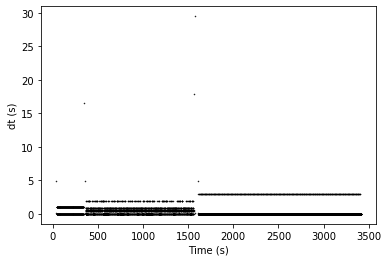

In [10]:
# ready to look at the events in seconds now!
plt.plot(evTS[:-1],np.diff(evTS),'k.',markersize=1)
plt.xlabel('Time (s)')
plt.ylabel('dt (s)')

As you can see in the plot, there are several different 'chunks' of similar events: these correspond to different stimulus blocks, where different types of stimuli were played. I typically try to use the messages to show the start of a block.

**Lets visualize this:**
On top of your evTS plot, plot a vertical red line where each `msgTS` occurred. For visualization, let's just make each line go from [0,30] on the y axis. I found this was simple to do with a loop through each message time.

Text(0, 0.5, 'dt (s)')

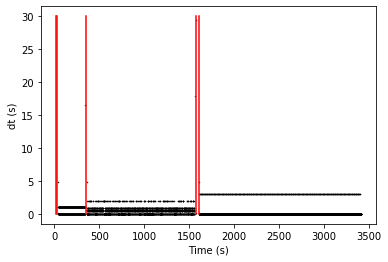

In [11]:
# look at where the messages were
plt.plot(evTS[:-1],np.diff(evTS),'k.',markersize=1)
for i,msg in enumerate(msgTS):
    plt.plot([msg,msg],[0,30],'r')
plt.xlabel('Time (s)')
plt.ylabel('dt (s)')

Cool! These lines look like they run right at the beginning of each block.

I will note that these are human generated timestamps, and are thus prone to error. In this case I did a decent job, and I can use these message times to cut up my data into separate chunks, *this is NOT guaranteed to work every time!*

Lets revisit our stimulus block labels again, in `msgText`:

In [12]:
msgText

array([b'site 3: laser test (power on 9.5, analog, bilateral)',
       b'block1: optotagging (2,10,25 ms pulse, 100 reps)',
       b'block2: clicksWithLaser (0-1V)',
       b'block3: contrastLaserInterleaved (2x 15 min reps, frozen noise over contrasts, 25Hz stimulation)',
       b'block3: contrastLaserInterleaved (2x 15 min reps, frozen noise over contrasts, 25Hz stimulation)'],
      dtype='|S513')

We want the block that has our DRC stimuli, these are the ones labelled 'contrastLaserInterleaved'.

Notice that there are two with the same label? Remember what I said about human errors... I probably forgot that I had sent the first message and sent it twice, and we can see that there are two message lines right before the last block: those are these two messages.

That aside, we just want the last one, which occurs right before the last stimulus block, which is the one we want to analyze.

**Try this:**
- pull out the timestamp of that last message into a variable called `blockStart`
- make a logical mask to select only the evTS greater than our block timestamp, call it `I`
- assign our masked timestamps to a variable called `blockEvTS`
- make a diff plot of `blockEvTS` as above

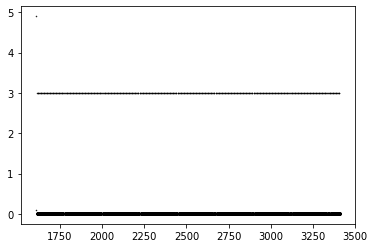

In [13]:
# now we can use the block labels to extract just the events we want
# extract the start of the last block
blockStart = msgTS[-1]

# get all the events after the last block started
I = evTS > blockStart
blockEvTS = evTS[I]
plt.plot(blockEvTS[:-1],np.diff(blockEvTS),'k.',markersize=1)


We're getting very close to looking at spikes! Bear with me!

In the plot you should see two nice lines, and maybe a couple points at the beginning that are off the lines.

To better understand this, we need to think about our stimuli...
* Each block is 3 seconds and is triggered with a 5ms event pulse.
* There are 600 blocks in this particular recording.
* This means that an array with just our contrast block events should be 600...

What is the length of your `blockEvTS` array?

In [14]:
len(blockEvTS)

31202

That is way too big!

This is because we didn't really care which events we put in blockEvTS, we just put all of them after the message we chose.

These events include:
- stimulus event onsets and offsets (these are on channel 1)
- laser event onsets and offsets (these are on channel 4)

We want to filter just the stim onsets. We can do this using our `evState` variable. This is an array the same length of our `evTS` array, but it tells you what each event was, 1 is stimOn, -1 is stimOff, 4 is laserOn, -4 is laserOff.

**Try this:**
1. Mask `evState` using our block index `I` from before into a variable called `blockEvState`.
2. Pull out only stimulus onset events from blockEvTS, save them to `stimOn`
3. Check the shape, if it's 601, you done good!
4. Plot the diff plot of `stimOn` as above.

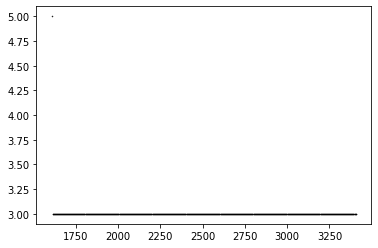

In [15]:
# first, pull out only events that are state 1 (stimulus rising)
blockEvState = evState[I]

stimOn = blockEvTS[blockEvState == 1]
stimOn.shape

# plot again
plt.plot(stimOn[:-1],np.diff(stimOn),'k.',markersize=1)

SO CLOSE! What does your plot look like?

You should see a line at 3s dt, then one dot at 5s. The 3s makes sense, this is the difference between our 3s block onsets!

The one dot at 5 is actually a feature of our stim presentation code (thanks Kath!). Each block is preceded by 5 seconds of silence, which is good for splitting blocks and for getting a baseline.

For now, we don't need that event, so remove it from `stimOn`, then replot your new diff plot.

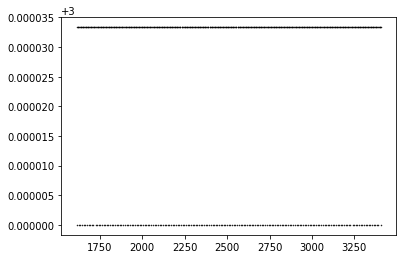

In [16]:
# finally remove the first event, it is a block start indicator
stimOn = stimOn[1:]
plt.plot(stimOn[:-1],np.diff(stimOn),'k.',markersize=1)

Ok, now you should just see two lines which are microseconds apart. This may look alarming, but it is just a sampling artifact. If you compute `1/fs`, you can see that the top line is just 1 sample longer than the bottom line, so no worries.

In [17]:
1/fs

3.3333333333333335e-05

Wow, that was a lot just for events... but now we're finally ready to get to the spikes!

## SPIKES

Remember way back in the beginning (it feels like forever ago, this takes a while to write...), we talked about spike times and spike identity. This data is saved in `'_data/spike_times.npy'` and `'_data/spike_clusters.npy'`.

Load these files to variables called `spikes` and `clust`, respectively. Look at the values, what are the shapes.

In [18]:
# events are done, now load spike data
clust = np.load(os.path.join(root,'spike_clusters.npy'))
spikes = np.load(os.path.join(root,'spike_times.npy'))

# look at the values, what are their shapes, what do you think they are?
print(spikes)
print(spikes.shape)
print(clust)
print(clust.shape)


[[     152]
 [     180]
 [     225]
 ...
 [97832635]
 [97832678]
 [97832687]]
(929663, 1)
[160  60 116 ...  49  92  38]
(929663,)


The values in `clust` are actually cell identity indices for each spike. So, it is the same size as `spikes`, and has a numerical value for each spike which tells us what cluster that spike came from.

Use this index to extract spikes from `clust == 26` and save in a new variable called `cSpikes`. Print the shape of the spikes for this cell, this corresponds to the number of spikes and look at the spike time values.

In [19]:
c = 26

cSpikes = spikes[clust == c]
print(cSpikes.shape)
cSpikes[0:10]

(11283, 1)


array([[  5424],
       [ 17830],
       [ 17986],
       [ 18298],
       [ 18457],
       [ 18782],
       [ 37292],
       [ 60120],
       [200175],
       [200436]], dtype=uint64)

The values are huge! Again, this is because spikes are recorded in samples from the **recording** onset (*unlike events, which are from the GUI start onset*). Redefine `cSpikes` so that it is in seconds.

In [20]:
cSpikes = cSpikes / fs

What if we want to know more information about our clusters? KiloSort2/Phy (our sorting software) outputs a file called `'_data/cluster_info.tsv'` that contains info about each cluster.

**Try this:**
1. Load this file using our old friend pandas, keeping in mind that the delimiters are tabs (hence, .tsv).
2. In the group column, you can see that a lot of the cells are labelled as noise... remove those rows from the dataframe
3. Save just the `id` column of our filtered data frame to a variable called `clustID`


(*we won't actually be using this information, but this seems like a handy thing to know for batch analysis*)

In [21]:
# load the cluster info using pandas
clustInfo = pd.read_csv(os.path.join(root,'cluster_info.tsv'),delimiter='\t')

# remove noise clusters
clustInfo = clustInfo[clustInfo.group != 'noise']

# extract the cell index
clustID = np.asarray(clustInfo.id)

As a sanity check, print the shape of `cSpikes`, which corresponds to the spike count, and look at the dataframe row for this cluster, the column named `n_spikes` should have the same number.

In [22]:
print(cSpikes.shape)
clustInfo[clustInfo.id==c]

(11283, 1)


,id,Amplitude,ContamPct,KSLabel,channel,depth,firing_rate,group,n_spikes
16,26,639.2,100.0,mua,7,775.0,3.5 spk/s,good,11283


## its psth time.

Lets get down to analysis, we're ready.




First, let's make a PSTH, or peri-stimulus time histogram (?), which is just binned spike counts relative to different stimulus onsets.

**To start:**
1. Define `binSize = .001`.
2. Make a variable called `edges` which is **a**   **range** from -.1 to 3.1 seconds, in steps of `binSize`. These are the bin edges of our histogram.
3. Make a time vector, which is the center of each pair of edge bins, call it `time`.

In [23]:
# bins and edges
binSize = .001
edges = np.arange(-.1,3.1,binSize)
time = edges[:-1] + np.diff(edges).mean() /2    

In [24]:
len(cSpikes)

11283

**Next:**
1. Zero your spikes to the first event in `stimOn` call the zeroed spikes `spks`.
2. Use numpy's `histogram` function to make a histogram of these zeroed spikes using our `edges`. Look at the help.
3. Plot the histogram counts as a function of `time`.

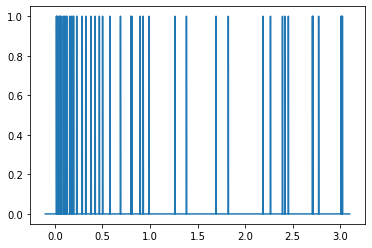

In [25]:
# zero spikes on first stim and compute histogram
spks = cSpikes - stimOn[0]
n,bin_edges = np.histogram(spks,bins=edges)
n = n
# plot
plt.plot(time,n)

Now you can see this vector goes to 1 with each spike! What we did was make a histogram for just one contrast block. 

Use a loop to make a full psth matrix, where each row is one of these block histograms. Make sure to divide each row you make by the binSize to convert to spike rate. Then plot your psth matrix using `plt.imshow` with aspect set to auto.

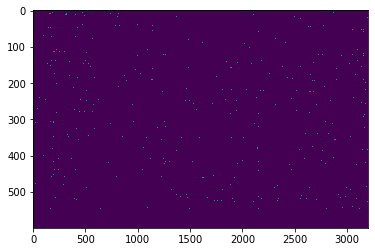

In [26]:
# make it a loop

# preallocate
psth = np.empty([len(stimOn),len(edges)-1])

for i,trig in enumerate(stimOn):
    
    # zero spikes
    spks = cSpikes - trig
    
    # spike histogram appended to PSTH
    psth[i,:],_ = np.histogram(spks,bins=edges)
    psth[i,:] = psth[i,:] / binSize

    

plt.imshow(psth,aspect='auto')

This is a quick and dirty way of visualizing responses over trials. However, imshow does some funky compression, so maybe a spike raster is a better visualization. Modify your for loop from before to also build a spike raster.

**Try this**:
1. Create two empty lists, `raster` and `trials`.
2. In your loop, populate `raster` with spike times corresponding to that trial (that is, spikes within the limits of edges)
3. Also populate `trials` with a trial index for each spike (so, if there are 3 spikes in trial 1, then 2 spikes in trial 2, trials will start as [1 1 1 2 2 ...]

(HINT: the list method `append` seems like the obvious choice here, but that will in fact create a list of arrays, when we just want a list of numbers that **extends** on each loop, there is a similarly named list method that can do this...)

In [27]:
# preallocate
raster = []
trials = []
psth = np.empty([len(stimOn),len(edges)-1])

for i,trig in enumerate(stimOn):
    
    # zero spikes
    spks = cSpikes - trig
    
    # spike histogram appended to PSTH
    psth[i,:],_ = np.histogram(spks,bins=edges)
    psth[i,:] = psth[i,:] / binSize
    
    # extend raster (using only spikes within each trial range)
    spks = spks[(spks>edges[0]) & (spks<edges[-1])]
    raster.extend(spks)
    trials.extend(np.ones(len(spks))*(i+1))

You should now have a list of spikes that are triggered to each trial event, and a corresponding index of the trial number for each spike. Now it is really easy to plot a raster using `plt.scatter`!

Make two subplots, plotting the psth from before in one, and plotting your spike raster in the other (make the raster marker size small, 1 looks good)

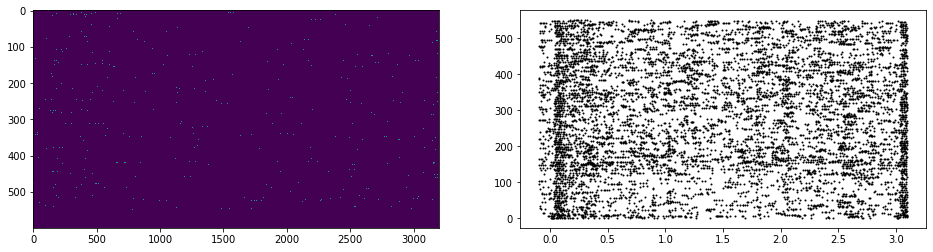

In [28]:
fig,ax = plt.subplots(1,2,figsize=[16,4])
ax[0].imshow(psth,aspect='auto')
ax[1].scatter(raster,trials,1,'k')

Great, now we have two representations of our data, one with spike resolution and one with PSTH resolution of 1ms!

This is the end of part 1, which is essentially preprocessing your data. In part 2, we will start to cover the analysis of single cells and populations.

Now we might want to start testing how different parameters of our stimuli affect neural responses. To do this we need to know what stimulus was played for each of our 600 trials.

This information is saved in `'_data/trialOrder.npy'`. Load this file into a variable called `order`. It should be 3 columns, with column 1 == 1 during low contrast and 2 during high contrast, column 2 == 0 when laser is off and 1 when on, and column 3 is a frozen noise pattern for the DRC.

How long is order?

In [29]:
# load stimulus info and sort by noise pattern
import numpy.matlib
order = np.load(os.path.join(root,'trialOrder.npy'))

Notice that `order` is 300 long? This is only half the length of our recorded event number (600). This is because I save a fixed order of the stimulus in 1 file, and repeat that as time allows for a recording; here I had two repeats.

To fix this, redefine `order` to be the same matrix repeated twice, your new `order` will be 600 rows x 3 columns. (there are several ways to achieve this)

In [30]:
order = np.matlib.repmat(order,2,1)
order.shape

(600, 3)

Now we know what stimuli were played when, and we can use order to index trials in our PSTH for averaging.

**Try this**:
1. Make an index for contrast from `order`.
2. Use the index to make an average PSTH response for low and high contrast.
3. Plot these means, in blue for low and red for high. Make sure to plot with the right time axis. There's a lot of overlap here, and the data aren't smoothed, so you can also play with the xlim to look only at the first 1s.

(0, 1)

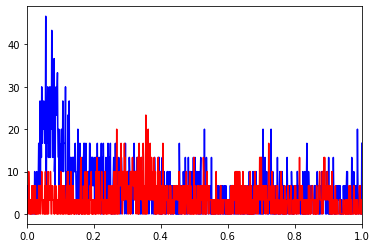

In [31]:
plt.plot(time,psth[order[:,0]==1,:].mean(axis=0),'b')
plt.plot(time,psth[order[:,0]==2,:].mean(axis=0),'r')
plt.xlim([0,1])

Lets try to quickly visualize the effects of contrast AND laser.

**Try this:**
1. Make a figure with two subplots.
2. In the first subplot, plot the mean temporal response during low contrast with the laser off in blue, and low contrast with laser on in black.
3. Do the same in the second subplot, but for high contrast, and color the laser off curve red.
4. Remember axis labels and titles.

Text(0.5, 1.0, 'High Contrast')

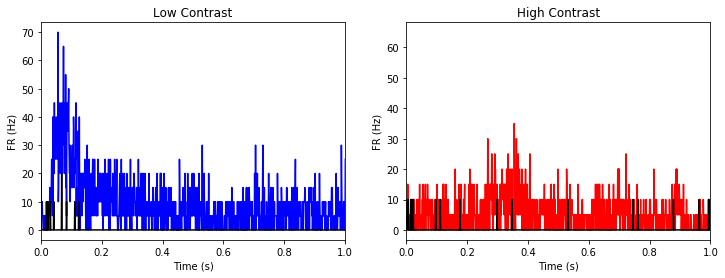

In [32]:
fig,ax = plt.subplots(1,2,figsize=[12,4])

ax[0].plot(time,psth[(order[:,0]==1)&(order[:,1]==0),:].mean(axis=0),'b')
ax[0].plot(time,psth[(order[:,0]==1)&(order[:,1]==1),:].mean(axis=0),'k')
ax[0].set_xlim([0,1])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FR (Hz)')
ax[0].set_title('Low Contrast')

ax[1].plot(time,psth[(order[:,0]==2)&(order[:,1]==0),:].mean(axis=0),'r')
ax[1].plot(time,psth[(order[:,0]==2)&(order[:,1]==1),:].mean(axis=0),'k')
ax[1].set_xlim([0,1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('FR (Hz)')
ax[1].set_title('High Contrast')

Now, you might want to save some of this data for later analysis. Remember in previous tutorials we covered the pickle method in Python. From what I understand, pickling is a way of saving variables in a file, like we would save Matlab variables in a .mat file. For easy access, lets pickle our data for later!

(note, I am also pulling out and saving the laser events for the next part of the tutorial)

In [33]:
fn = os.path.join(root,'sessionInfo.pkl')

laserOn = blockEvTS[blockEvState == 4]

# remember this `with` command cleanly closes files once they've been opened, even if there is a write error
with open(fn,'wb') as f:
    pickle.dump([order, clustInfo, fs, stimOn, laserOn],f)

<br/><br/>
## BONUS ##

So far we've converted our spike data into a PSTH matrix that is really easy to work with. I think this covers the basics of getting started with analysis, most of my analyses stem from using these PSTH matrices.

In this last part, I want to cover a bit more advanced visualization of the raw data. PSTHs are nice, but they are not quite as nice as seeing your effects in a spike raster! I think presenting spike rasters in a way that can show stimulus effects is very valuable!

The approach I usually take is to sort my rasters by different conditions, this lets you see by eye how the spike patterns change.

First, we want to generate a sorting index. This will rearrange our trials such that all the trials of one type are presented together, then all the trials of the next type and so on. 

**Goal:**
Create an index to sort our trials by contrast condition.

There is a numpy function for this, and it is not called `sort`, but does have the word sort in it... if you run `np.sort`, it will return just a sorted version of the vector you give it, we want the trial order that gives this sorting.

**IMPORTANT:** once you get your sorting index, add 1 to it... this will make trial 1 == 1, trial 2 == 2 etc., which is necessary later.

In [34]:
sortI = np.argsort(order[:,0])+1

A quick and dirty method of visualizing the effect of sorting is to sort and plot your PSTH with your index, but this doesn't look great, lets try sorting the raster next:

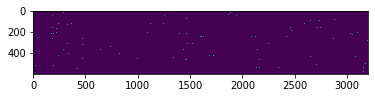

In [35]:
plt.imshow(psth[sortI-1,:])

What we want to do is take our `trials` variable, and resort it according to `sortI`. There is a REALLY easy way to do this in matlab with the `ismember` function, but python doesn't have anything similar to that. I've written a function that sort of replicates this functionality below (see the comments for what this function does).

In [36]:
# aside: writing external functions
def ismember(A,B):
    """replaces values in A with the index of their matches in B"""

    # This function takes two arrays, A and B, and checks for matches.
    # Where A matches B, those values of A are replaced by their index in B.
    # This index is returned in res.

    # convert both A and B to np arrays
    A = np.asarray(A).astype(int)
    B = np.asarray(B).astype(int)

    # preallocate res
    res = np.zeros(A.shape)

    # loop through unique values of A
    for i in np.unique(A):

        # where A == i, replace them with the index of i in B
        res[A == i] = np.argwhere(B == i).squeeze()

    return res

**Try this:**
1. Run this function on our data, to sort `trials` by `sortI`, setting the new sorted trials to `sortSpikeTrials`.
2. Plot the sorted version of the raster.

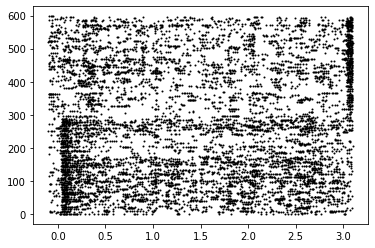

In [37]:
sortSpikeTrials = ismember(trials,sortI)
plt.scatter(raster,sortSpikeTrials,1,'k')

You should see a really distinct split between the top and bottom half of the data, reflecting the timecourse of our PSTH averages from before, neat!

Now do the same thing, but instead of sorting by contrast, sort by laser (column 2 of order).

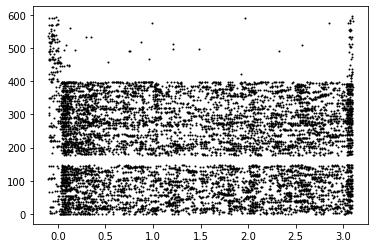

In [38]:
sortI = np.argsort(order[:,1])+1
spikeSortI = ismember(trials,sortI)

plt.scatter(raster,spikeSortI,1,'k')

Finally, visualize the sorting by noise pattern.

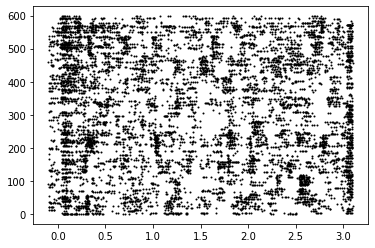

In [39]:
sortI = np.argsort(order[:,2])+1
spikeSortI = ismember(trials,sortI)

plt.scatter(raster,spikeSortI,1,'k')

Great! While visualizing the rasters this way is not necessary for analyzing your data, I find it very useful and a good way to make pretty figures for publication.